In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install tensorflow-gpu==2.3.0
!pip install keras==2.4.3
!pip install wget

In [1]:
import wget

apple2orange = "https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip"

wget.download(apple2orange, "apple2orange.zip")

 13% [.........                                                               ] 10797056 / 78456409

KeyboardInterrupt: 

In [2]:
from zipfile import ZipFile
file_name = "apple2orange.zip"
with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('Done!')

Done!


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import time

In [3]:
devices = tf.config.experimental.get_visible_devices("GPU")
tf.config.experimental.set_memory_growth(device=devices[0], enable = True)

In [4]:
path = "apple2orange/"
trainA, trainB, testA, testB = "trainA", "trainB", "testA","testB"
trainA = [os.path.join(path, trainA) + "/" + i for i in os.listdir(path + trainA)]
trainB = [os.path.join(path, trainB) + "/" +i for i in  os.listdir(path + trainB)]
testA = [os.path.join(path, testA) + "/" +i for i in os.listdir(path + testA)]
testB = [os.path.join(path, testB) + "/" +i for i in os.listdir(path + testB)]

In [5]:
def load(image):
    image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [256,256], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image

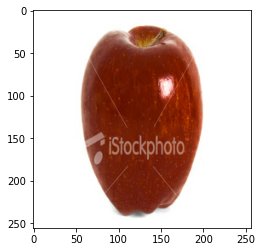

In [6]:
image = load(trainA[0])
plt.imshow(image/255.0)

In [7]:
def random_crop(image):
    return tf.image.random_crop(image, size = [256,256,3],)

In [8]:
def normalize(image):
    return (image / 127.5) - 1

In [9]:
def random_jitter(image):
    image = tf.image.resize(image, [286,286], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = random_crop(image)
    image = tf.image.random_flip_left_right(image)
    return image

In [10]:
def preprocess_image_train(image):
    image = load(image)
    image = random_jitter(image)
    image = normalize(image)
    return image

In [11]:
def preprocess_image_test(image):
    image = load(image)
    image  = normalize(image)
    return image

In [12]:
trainA = tf.data.Dataset.from_tensor_slices((trainA))
trainB = tf.data.Dataset.from_tensor_slices((trainB))
testA = tf.data.Dataset.from_tensor_slices((testA))
testB = tf.data.Dataset.from_tensor_slices((testB))

In [13]:
trainA = trainA.map(preprocess_image_train).cache().shuffle(100).batch(1)
trainB = trainB.map(preprocess_image_train).cache().shuffle(100).batch(1)
testA = testA.map(preprocess_image_test).cache().batch(1)
testB = testB.map(preprocess_image_test).cache().batch(1)

In [14]:
train, label = next(iter(trainA)), next(iter(trainB))
print(train.shape, label.shape)

(1, 256, 256, 3) (1, 256, 256, 3)


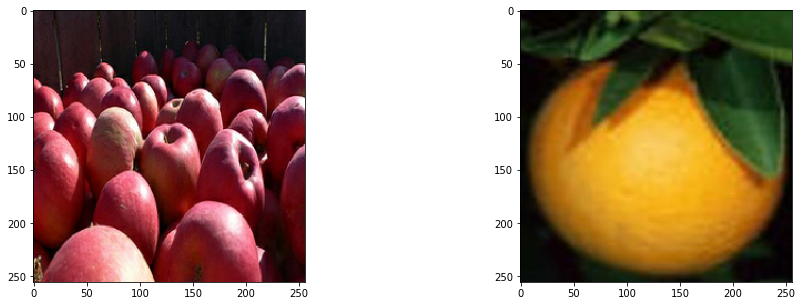

In [15]:
fig, axes = plt.subplots(1,2, figsize = (16,5))
axes[0].imshow(train[0] * 0.5 + 0.5)
axes[1].imshow(label[0] * 0.5 + 0.5)

In [16]:
OUTPUT_CHANNELS = 3
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type="instancenorm")
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type="instancenorm")

discriminator_x = pix2pix.discriminator(norm_type="instancenorm", target = False)
discriminator_y = pix2pix.discriminator(norm_type="instancenorm", target = False)

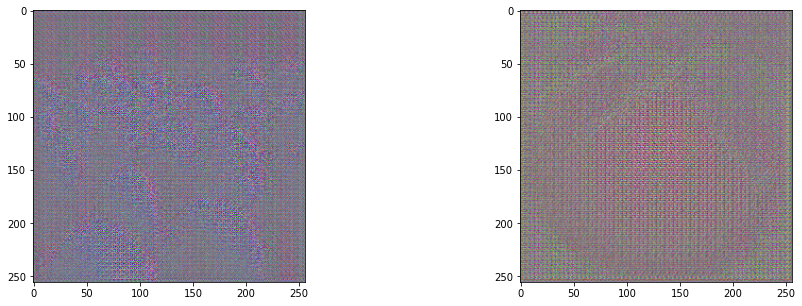

In [17]:
to_orange = generator_g(train)
to_apple = generator_f(label)
fig, axes = plt.subplots(1,2, figsize = (16, 5))
axes[0].imshow(to_orange[0] * 0.5 + 0.5)
axes[1].imshow(to_apple[0] * 0.5 + 0.5)

In [18]:
LAMBDA = 10
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [19]:
def discriminator_loss(real, generated):
    real_loss = loss(tf.ones_like(real), real)
    generated_loss = loss(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

In [20]:
def generator_loss(generated):
    return loss(tf.ones_like(generated), generated)

In [21]:
def calc_cycle_loss(real_image, cycle_image):
    loss = tf.reduce_mean(tf.abs(real_image- cycle_image))
    return LAMBDA * loss

In [22]:
def identify_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [23]:
generator_g_opti = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_opti = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_opti = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_opti = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [24]:
def generate_images(model, test_input, epoch):
    prediction = model(test_input)
    display = [test_input[0], prediction[0]]
    fig, axes = plt.subplots(1,2, figsize = (9,9))
    title = ["Input image", "Generated image"]
    for i in range(2):
        axes[i].imshow(display[i] * 0.5 + 0.5)
        axes[i].set_title(title[i])
    plt.axis("off")
    plt.savefig("output/output_{}.jpg".format(epoch))
    plt.close()

In [25]:
output_dir = "output/"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [26]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training = True)
        cycle_x = generator_f(fake_y, training = True)
        
        fake_x = generator_f(real_y, training = True)
        cycle_y = generator_g(fake_x, training = True)
        
        same_x = generator_f(real_x, training = True)
        same_y = generator_g(real_y, training = True)
        
        disc_real_x = discriminator_x(real_x, training = True)
        disc_real_y = discriminator_y(real_y, training = True)
        
        disc_fake_x = discriminator_x(fake_x, training = True)
        disc_fake_y = discriminator_y(fake_y, training = True)
        
        #calculate loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        total_cycle_loss = calc_cycle_loss(real_x, cycle_y) + calc_cycle_loss(real_y, cycle_y)
        
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identify_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identify_loss(real_x, same_x)
        
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    generator_g_grad = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_grad = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    
    discriminator_x_grad = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_grad = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    
    # optimizer
    generator_g_opti.apply_gradients(zip(generator_g_grad, generator_g.trainable_variables))
    generator_f_opti.apply_gradients(zip(generator_f_grad, generator_f.trainable_variables))
    discriminator_x_opti.apply_gradients(zip(discriminator_x_grad, discriminator_x.trainable_variables))
    discriminator_y_opti.apply_gradients(zip(discriminator_y_grad, discriminator_y.trainable_variables))
    return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

In [27]:
EPOCHS = 40
for epoch in range(EPOCHS):
    start = time.time()
    n = 0
    for image_x, image_y in tf.data.Dataset.zip((trainA, trainB)):
        gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss = train_step(image_x, image_y)
    print(f"Epoch: {epoch + 1} G_g_loss: {gen_g_loss} G_f_loss: {gen_f_loss} disc_x_loss: {disc_x_loss} disc_y_loss: {disc_y_loss}")
    test = next(iter(testA))
    generate_images(generator_g, test, epoch)
    print(f"Time taken for epoch {epoch} is {time.time() - start} seconds")

Epoch: 1 G_g_loss: 9.462963104248047 G_f_loss: 8.259766578674316 disc_x_loss: 0.584152102470398 disc_y_loss: 0.46848851442337036
Time taken for epoch 0 is 796.0666842460632 seconds


KeyboardInterrupt: 

In [29]:
if not os.path.exists("weights/"):
        os.mkdir("weights/")

generator_f.save_weights("weights/generator_f.h5")
generator_g.save_weights("weights/generator_g.h5")
discriminator_x.save_weights("weights/disc_x.h5")
discriminator_y.save_weights("weights/disc_y.h5")

In [30]:
generator_f.load_weights("weights/generator_f.h5")
generator_g.load_weights("weights/generator_g.h5")
discriminator_x.load_weights("weights/disc_x.h5")
discriminator_y.load_weights("weights/disc_y.h5")

KeyboardInterrupt: 

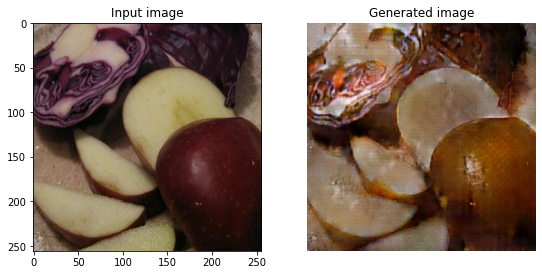

In [31]:
n = 40
for i in testA:
    generate_images(generator_g, i, n)
    n+=1

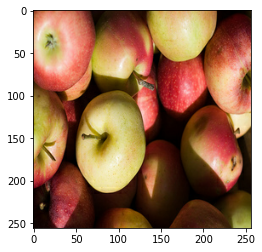

In [35]:
image = preprocess_image_test("apple2orange/testA/n07740461_14621.jpg")
image = image[tf.newaxis, :]
plt.imshow(image[0] * 0.5 + 0.5)

In [36]:
pred = generator_g(image)
pred.shape

TensorShape([1, 256, 256, 3])

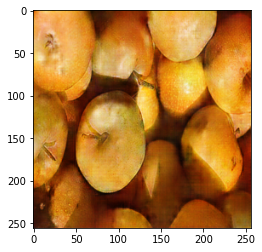

In [37]:
plt.imshow(pred[0] * 0.5 + 0.5)